# Загрузка библиотек

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nbformat
import plotly.graph_objects as go 

from scipy.stats import normaltest, levene, norm
from scipy.optimize import curve_fit
from scipy.stats import f_oneway
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft


sns.set_theme()
sns.set_palette("deep")

In [3]:
data_bpm = []
for i in range(1, 25):
    line_data = np.fromfile(f'data/data_bpm{i}.bin', dtype='short')
    data = line_data.reshape(-1, 4)
    df = pd.DataFrame(data, columns=['A', 'B', 'C', 'D'])
    data_bpm.append(df)
data_bpm[0]

A     B     C     D
0       -833 -1444 -1334 -1426
1       -643 -1234 -1104 -1402
2       -675 -1351 -1139 -1428
3       -583 -1502 -1147 -1385
4       -527 -1623  -995 -1265
...      ...   ...   ...   ...
249995 -1651 -2228 -2346 -2667
249996 -1789 -1987 -2276 -2519
249997 -2033 -1933 -2349 -2243
249998 -2215 -1868 -2448 -2181
249999 -2023 -1818 -2512 -2423

[250000 rows x 4 columns]

# Оптимизированный код

In [4]:
period = 368
data = data_bpm[0].iloc[20*period:].reset_index().drop('index', axis=1)

In [5]:
data

A     B     C     D
0      -3377 -2785 -3730 -3637
1      -3447 -2586 -3584 -3665
2      -3471 -2543 -3449 -3714
3      -3501 -2664 -3494 -3493
4      -3571 -2631 -3652 -3498
...      ...   ...   ...   ...
242635 -1651 -2228 -2346 -2667
242636 -1789 -1987 -2276 -2519
242637 -2033 -1933 -2349 -2243
242638 -2215 -1868 -2448 -2181
242639 -2023 -1818 -2512 -2423

[242640 rows x 4 columns]

In [6]:
def plot(data: pd.DataFrame, period: int, number_of_periods: int, start_record_number: int=0, columns=None, **plot_params):
    columns = columns if columns else data.columns
    data[start_record_number: start_record_number + number_of_periods*period][columns].plot(**plot_params)
    for i in range(number_of_periods+1):
        plt.axvline(x=start_record_number+i*period, ls='--', color='gray')

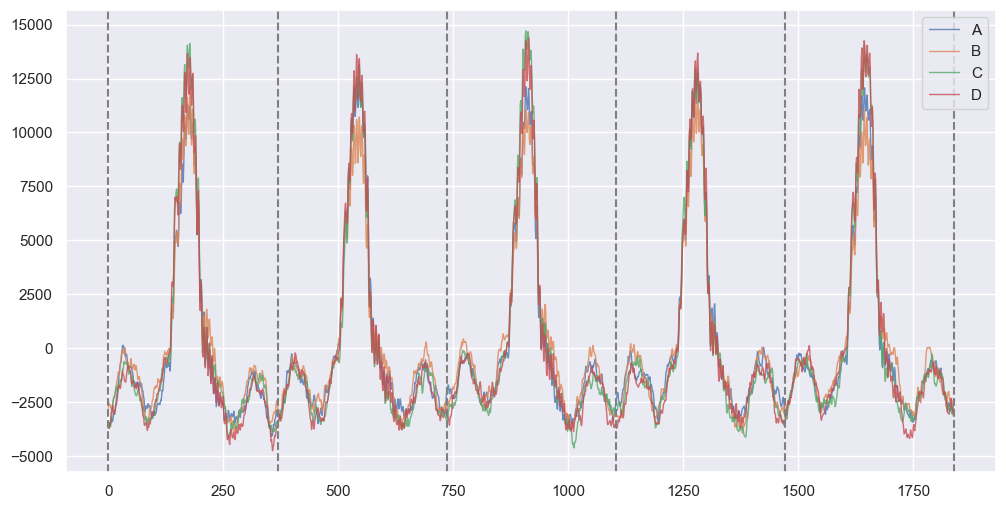

In [7]:
plot(data=data, period=period, start_record_number=0, number_of_periods=5, columns=[],
    lw=1, alpha=.8, figsize=(12, 6))

In [8]:
def periods_data(data: pd.Series, period: int):
    number_of_records = len(data)
    periods = data[:number_of_records // period * period].to_numpy().reshape(-1, period)
    periods_data = pd.DataFrame(periods.T)
    return periods_data

In [9]:
def periods_data_parameter(data: pd.Series, period: int, parameter: str, columns=[]):
    columns = columns if columns else data.columns
    result = pd.DataFrame()
    for column in columns:
        result[column] = periods_data(data[column], period).agg(parameter)
    return result

## Средние

<AxesSubplot:xlabel='Number of period', ylabel='Mean'>

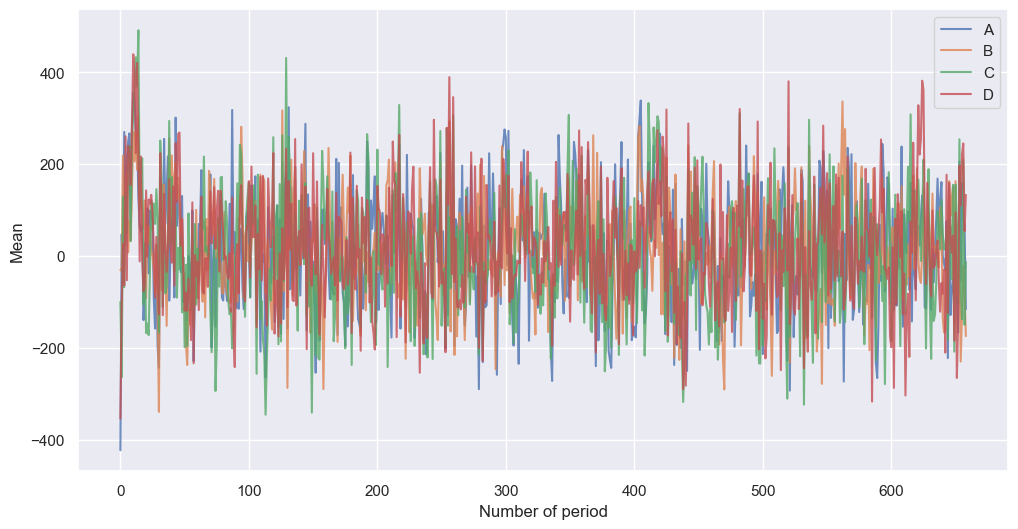

In [10]:
mean_data = periods_data_parameter(data, period, 'mean')
mean_data.plot(xlabel='Number of period', ylabel='Mean', alpha=.8, figsize=(12, 6))

In [11]:
f_oneway(mean_data['A'], mean_data['B'], mean_data['C'], mean_data['D'])

F_onewayResult(statistic=1.6097871856027783, pvalue=0.18500232290497012)

In [12]:
pd.DataFrame(mean_data.mean(), columns=['Mean'])

Mean
A   9.001765
B  11.046596
C   6.507381
D  20.735667

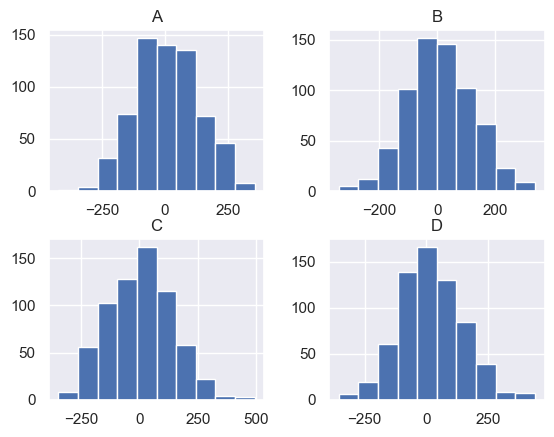

In [13]:
mean_data.hist();

In [14]:
pd.DataFrame(mean_data.mean(), columns = ['Mean of mean'])

Mean of mean
A      9.001765
B     11.046596
C      6.507381
D     20.735667

In [15]:
levene(*mean_data.to_numpy().T)

LeveneResult(statistic=8.867400015677692, pvalue=7.589655749870371e-06)

In [16]:
pd.DataFrame(mean_data.var(), columns = ['Variance of means'])

Variance of means
A       16233.679269
B       12427.469528
C       18513.976599
D       16279.328145

In [17]:
data_mean = periods_data_parameter(data, period, 'mean')

test_anova, p_anova = f_oneway(data_mean['A'], data_mean['B'], data_mean['C'], data_mean['D'])
test_leven, p_leven = levene(data_mean['A'], data_mean['B'], data_mean['C'], data_mean['D'])

print(f'Критериый о равенстве средних: \nStatistics = {test_anova}, p-value = {p_anova}\n')
print(f'Критериый о равенстве дисперсий: \nStatistics = {test_leven}, p-value = {p_leven}')

Критериый о равенстве средних: 
Statistics = 1.6097871856027783, p-value = 0.18500232290497012

Критериый о равенстве дисперсий: 
Statistics = 8.867400015677692, p-value = 7.589655749870371e-06


## Среднеквадратичные отклонения

<AxesSubplot:xlabel='Number of period', ylabel='Standart deviation'>

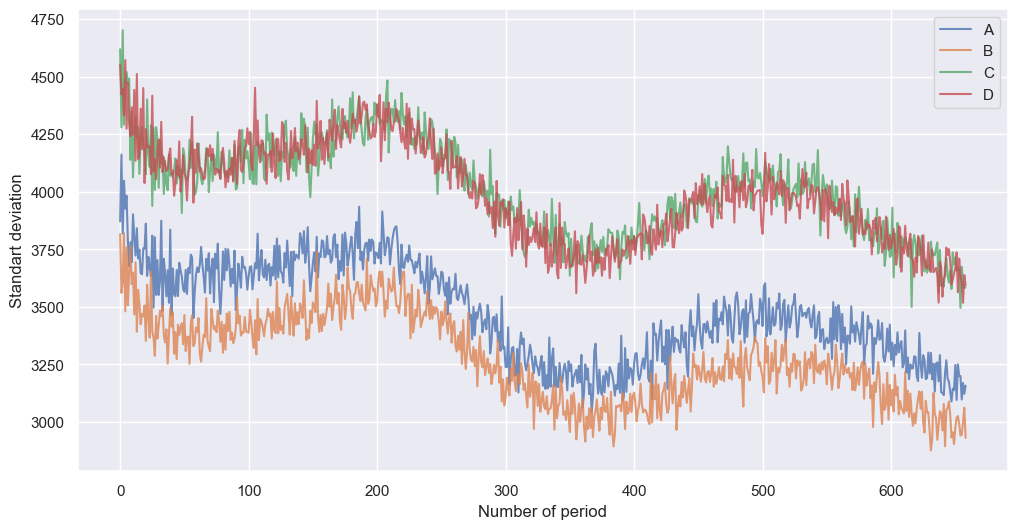

In [18]:
std_data = periods_data_parameter(data, period, 'std')
std_data.plot(xlabel='Number of period', ylabel='Standart deviation', alpha=.8, figsize=(12, 6))

In [19]:
f_oneway(*std_data.to_numpy().T)

F_onewayResult(statistic=2146.237918716715, pvalue=0.0)

In [20]:
levene(*std_data.to_numpy().T)

LeveneResult(statistic=4.1068339924078305, pvalue=0.00644072605719384)

array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'B'}>],
       [<AxesSubplot:title={'center':'C'}>,
        <AxesSubplot:title={'center':'D'}>]], dtype=object)

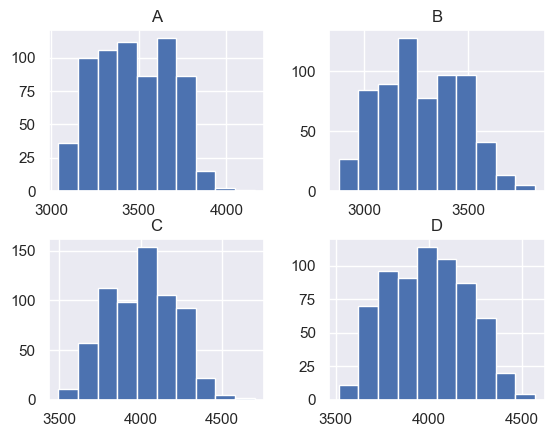

In [21]:
std_data.hist()

In [22]:
data_std = periods_data_parameter(data, period, 'std')

test_anova, p_anova = f_oneway(data_std['A'], data_std['B'], data_std['C'], data_std['D'])
test_leven, p_leven = levene(data_std['A'], data_std['B'], data_std['C'], data_std['D'])

print(f'Критериый о равенстве средних: \nStatistics = {test_anova}, p-value = {p_anova}\n')
print(f'Критериый о равенстве дисперсий: \nStatistics = {test_leven}, p-value = {p_leven}')

Критериый о равенстве средних: 
Statistics = 2146.237918716715, p-value = 0.0

Критериый о равенстве дисперсий: 
Statistics = 4.1068339924078305, p-value = 0.00644072605719384


## Максимумы

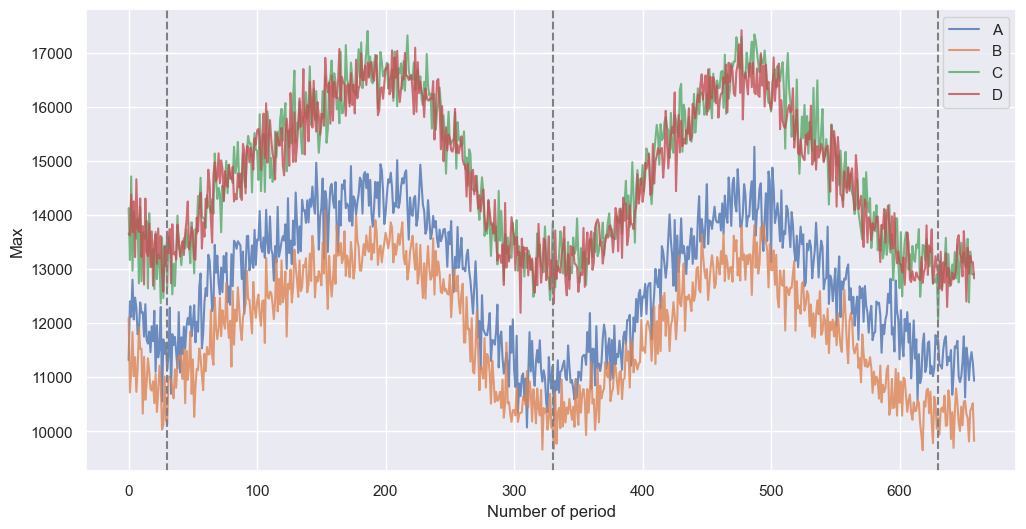

In [23]:
max_data = periods_data_parameter(data, period, 'max')
max_data.plot(xlabel='Number of period', ylabel='Max', alpha=.8, figsize=(12, 6))
plt.axvline(x=30, ls='--', color='gray')
plt.axvline(x=330, ls='--', color='gray')
plt.axvline(x=630, ls='--', color='gray')

In [24]:
f_oneway(*max_data.to_numpy().T)

F_onewayResult(statistic=927.2447376397844, pvalue=0.0)

In [25]:
levene(*max_data.to_numpy().T)

LeveneResult(statistic=18.439693411518586, pvalue=7.739939818468324e-12)

array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'B'}>],
       [<AxesSubplot:title={'center':'C'}>,
        <AxesSubplot:title={'center':'D'}>]], dtype=object)

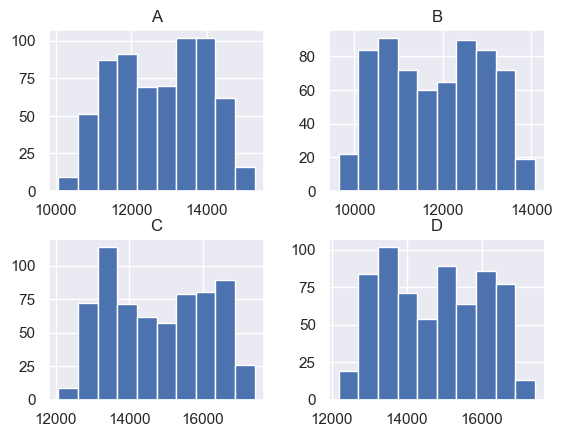

In [26]:
max_data.hist()

In [27]:
data_max = periods_data_parameter(data, period, 'max')

test_anova, p_anova = f_oneway(data_max['A'], data_max['B'], data_max['C'], data_max['D'])
test_leven, p_leven = levene(data_max['A'], data_max['B'], data_max['C'], data_max['D'])

print(f'Критериый о равенстве средних: \nStatistics = {test_anova}, p-value = {p_anova}\n')
print(f'Критериый о равенстве дисперсий: \nStatistics = {test_leven}, p-value = {p_leven}')

Критериый о равенстве средних: 
Statistics = 927.2447376397844, p-value = 0.0

Критериый о равенстве дисперсий: 
Statistics = 18.439693411518586, p-value = 7.739939818468324e-12


## Минимумы

<AxesSubplot:xlabel='Number of period', ylabel='Min'>

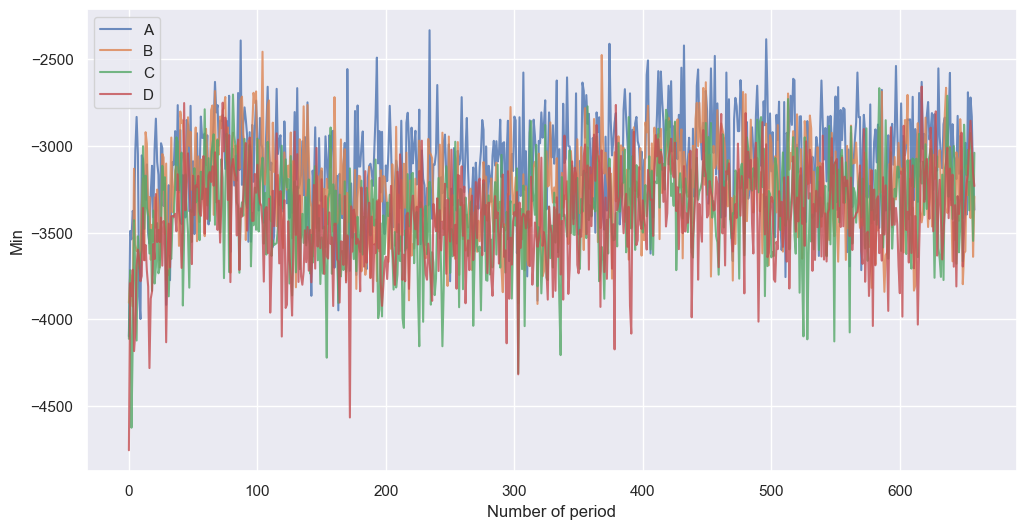

In [28]:
min_data = periods_data_parameter(data, period, 'min')
min_data.plot(xlabel='Number of period', ylabel='Min', alpha=.8, figsize=(12, 6))

In [29]:
f_oneway(*min_data.to_numpy().T)

F_onewayResult(statistic=193.44536486440276, pvalue=2.2972062266616695e-113)

In [30]:
levene(*min_data.to_numpy().T)

LeveneResult(statistic=0.08628145605491191, pvalue=0.967566796981439)

array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'B'}>],
       [<AxesSubplot:title={'center':'C'}>,
        <AxesSubplot:title={'center':'D'}>]], dtype=object)

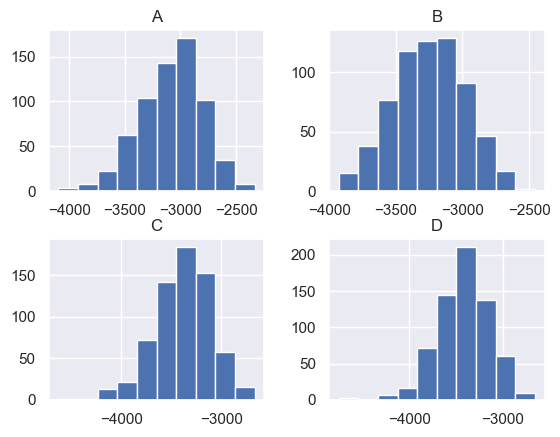

In [31]:
min_data.hist()

In [32]:
data_min = periods_data_parameter(data, period, 'min')

test_anova, p_anova = f_oneway(data_min['A'], data_min['B'], data_min['C'], data_min['D'])
test_leven, p_leven = levene(data_min['A'], data_min['B'], data_min['C'], data_min['D'])

print(f'Критериый о равенстве средних: \nStatistics = {test_anova}, p-value = {p_anova}\n')
print(f'Критериый о равенстве дисперсий: \nStatistics = {test_leven}, p-value = {p_leven}')

Критериый о равенстве средних: 
Statistics = 193.44536486440276, p-value = 2.2972062266616695e-113

Критериый о равенстве дисперсий: 
Statistics = 0.08628145605491191, p-value = 0.967566796981439


In [33]:
for i in min_data.columns:
    print(f'{i}: p-value = {normaltest(min_data[i]).pvalue}')

A: p-value = 0.0002114646565843152
B: p-value = 0.051744508951062036
C: p-value = 4.8301333964867485e-06
D: p-value = 1.5868037787062319e-06


## Распределения

In [34]:
z_data = periods_data(data['A'], period)

fig = go.Figure(data=[go.Surface(z=z_data.values)])

fig.update_layout(title='A period', autosize=False,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [35]:
hist_data = z_data[0].loc[z_data[0] > 0]

<AxesSubplot:>

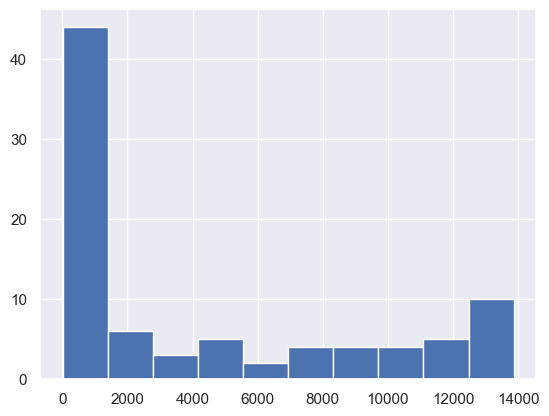

In [36]:
i = 535
hist_data = z_data[i].loc[z_data[i] > 0]
hist_data.hist()

# Координаты центра масс

<AxesSubplot:>

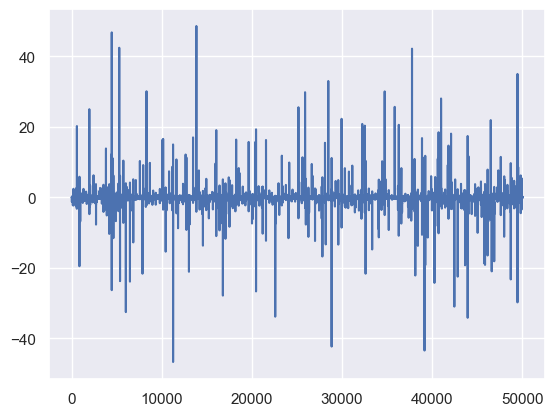

In [37]:
ac_data = ((data['A'] - data['C']) / (data['A'] + data['C']))
ac_data.loc[abs(ac_data)<50].iloc[:50_000].plot()

<AxesSubplot:>

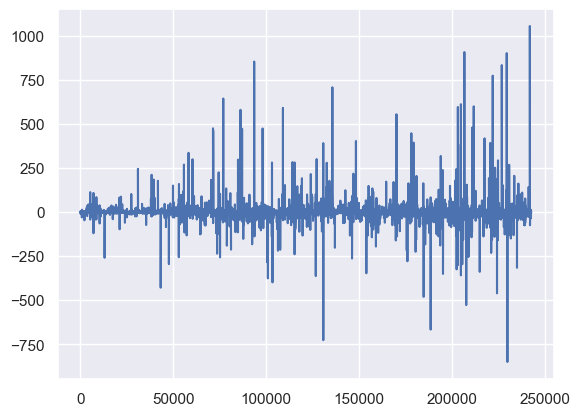

In [38]:
bd_data = ((data['B'] - data['D']) / (data['B'] + data['D']))
bd_data.plot()

In [39]:
bd_data[:1000].mean()

-0.19720537307755576

In [40]:
bd_data.to_numpy().shape

(242640,)

# Применение Фурье анализа

## Scipy

In [ ]:
SAMPLE_RATE = 250 * 10^6
DURATION = period

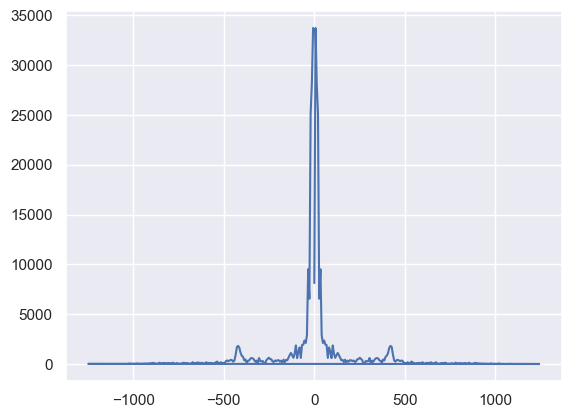

In [57]:
N = 368 # SAMPLE_RATE * DURATION
T = 1 / SAMPLE_RATE

signal = periods_data(data['A'], period)[0]

yf = fft(signal, norm='ortho')
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

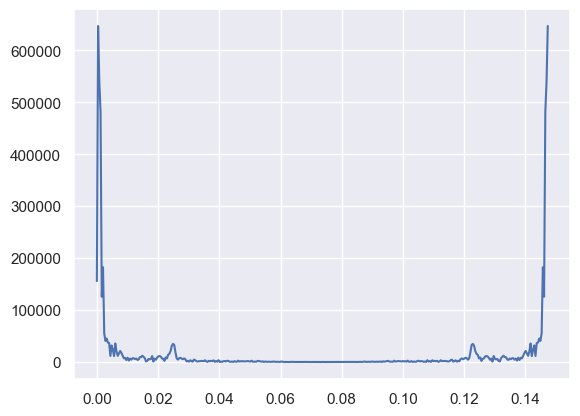

In [58]:
N = 368 # SAMPLE_RATE * DURATION
T = 1 / SAMPLE_RATE

x = np.linspace(0.0, N*T, N)
signal = periods_data(data['A'], period)[0]

# yf = fft(signal, norm='ortho')
yf = fft(signal)

xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(x, np.abs(yf))
plt.show()

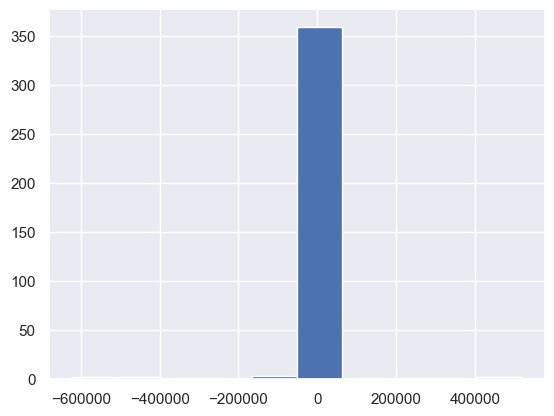

In [54]:
plt.hist(yf);

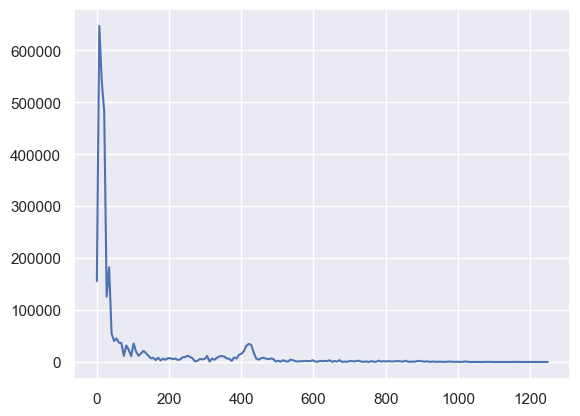

In [42]:
# обратите внимание на r в начале имён функций
yf = rfft(signal)
xf = rfftfreq(N, 1/SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

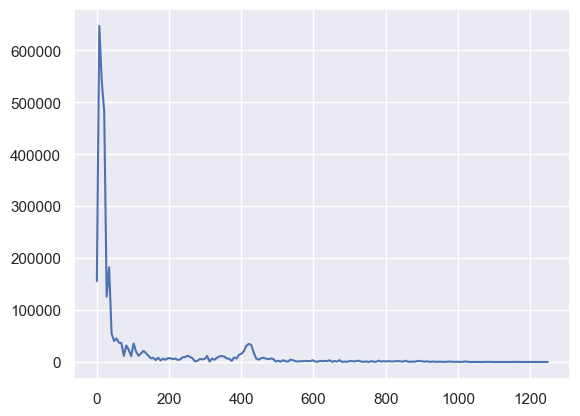

In [43]:
# Максимальная частота составляет половину частоты дискретизации
points_per_freq = len(xf) / (SAMPLE_RATE / 2)

# Наша целевая частота - 4000 Гц
target_idx = int(points_per_freq * 4000)
yf[target_idx-2:target_idx+2] = 0

plt.plot(xf, np.abs(yf))
plt.show()

## NumPy

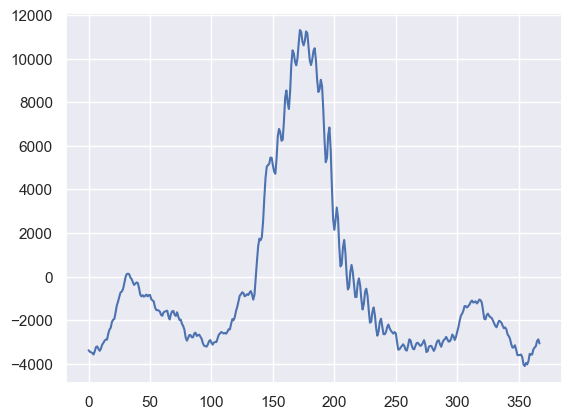

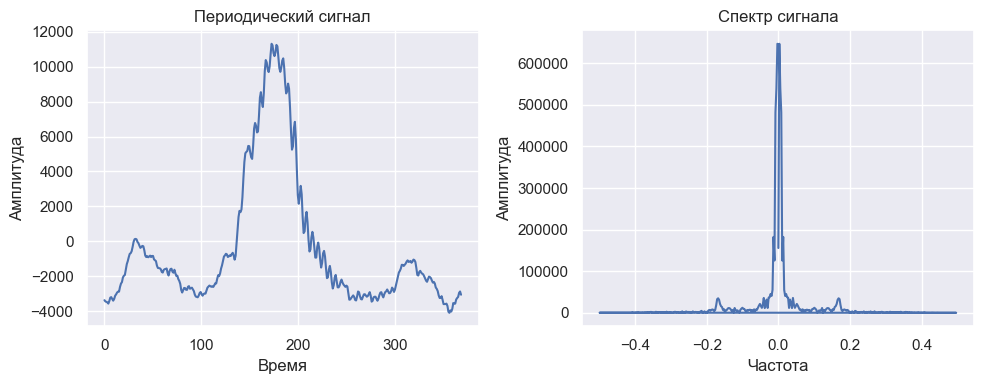

In [44]:
periods_data(data['A'], period)[0].plot()
t = np.linspace(0, 1, 368)
t = np.linspace(0, 368, 368) # Временные отсчеты

signal = periods_data(data['A'], period)[0] # Периодический сигнал

# Выполняем преобразование Фурье
fft_result = np.fft.fft(signal)

# Вычисляем частоты, соответствующие результатам преобразования Фурье
freqs = np.fft.fftfreq(len(signal), t[1] - t[0])

# Выводим результаты
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(t, signal)
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.title('Периодический сигнал')

plt.subplot(122)
plt.plot(freqs, np.abs(fft_result))
plt.xlabel('Частота')
plt.ylabel('Амплитуда')
plt.title('Спектр сигнала')

plt.tight_layout()
plt.show()


# BPM data at Booster Injection with full and truncated injection

## Data reading

In [114]:
skip = 8 * 6300 // 2
len_data = 4 * 1024**2
ofs = 220
delta_T = (250 * 10**6)**(-1)

In [115]:
data_bpm = []

line_data = np.fromfile(r'bpm_data\11_01_booster_libera08_hbpm3_1_full', dtype='int16')
data = line_data[skip:skip + len_data].reshape(-1, 4)
df = pd.DataFrame(data, columns=['A', 'B', 'C', 'D'])
data_bpm.append(df)

data_bpm[0]

A    B    C    D
0       -147 -273 -406   79
1       -157 -196 -416  321
2         17 -124 -416  383
3        373  -29 -415  230
4        247  -82 -421 -149
...      ...  ...  ...  ...
1048571  496  365   32  438
1048572  526  141  228  682
1048573  614  271  132  356
1048574  486  376  130  -11
1048575  134  134  139  138

[1048576 rows x 4 columns]

In [117]:
data_signal = data_bpm[0]

In [118]:
N = line_data.shape[0] // 4
N

2000000

In [122]:
sx = data_signal['A'] + data_signal['C']
delta_x = data_signal['A'] - data_signal['C']

sy = data_signal['B'] + data_signal['D']
delta_y = data_signal['B'] - data_signal['D']

In [121]:
delta_T * 390625 * 1024 / 4

0.4

## Finding revolution period 

In [1]:
def RevPer(sx): 
    yf = fft(sx)
    idx = np.argmax(np.abs(yf))
    period = len(data) / idx

    return period

In [60]:
N_compres = 10
N_FFT = 32 * 2048
N_fp = 20
delta_per = 0.005
N_fit = 5

A_x = 64
A_y = 33

In [3]:
def GetPos(s, delta, N_st, L_per):

    m_11, m_12 = 0, 0
    y_11, y_21 = 0, 0

    for k in range(L_per-1):
        m_11 += s[N_st+k] ** 2
        m_12 += s[N_st+k]

    M = np.array([[m_11, m_11], [m_12, L_per]])

    for k in range(L_per-1):
        y_11 += s[N_st+k] * delta[N_st+k]
        y_21 += delta[N_st+k]
    
    Y = np.array([y_11, y_21])

    R = np.linalg.inv(M) @ Y

    return R


In [143]:
def GetPos2(s, delta, N_st, L_per):
    m_11, m_12, y_1, y_2 = 0, 0, 0, 0

    for k in range(L_per-1):
        m_11 += s[N_st+k]**2
        m_12 += s[N_st+k]
        y_1 += s[N_st+k] * delta[N_st+k]
        y_2 += delta[N_st+k]

    R = ((m_12 * y_2) - (L_per * y_1)) / (m_12 ** 2 - m_11 * L_per)

    return R


In [144]:
j = np.arange(0, 493-1)

s_t = np.floor(j * 2128.751)

In [145]:
GetPos2(sx, delta_x, s_t, L_per=2128)

0         -21871
2128       -2288
4257        6720
6386       22416
8515      -26864
           ...  
1036701    15129
1038830     1028
1040959    -5047
1043087    16960
1045216     9540
Length: 492, dtype: int16
0         NaN
2128      NaN
4257      NaN
6386      NaN
8515      NaN
           ..
1036701   NaN
1038830   NaN
1040959   NaN
1043087   NaN
1045216   NaN
Length: 492, dtype: float64
0         NaN
2128      NaN
4257      NaN
6386      NaN
8515      NaN
           ..
1036701   NaN
1038830   NaN
1040959   NaN
1043087   NaN
1045216   NaN
Length: 492, dtype: float64
0         NaN
2128      NaN
4257      NaN
6386      NaN
8515      NaN
           ..
1036701   NaN
1038830   NaN
1040959   NaN
1043087   NaN
1045216   NaN
Length: 492, dtype: float64
0         NaN
2128      NaN
4257      NaN
6386      NaN
8515      NaN
           ..
1036701   NaN
1038830   NaN
1040959   NaN
1043087   NaN
1045216   NaN
Length: 492, dtype: float64
0         NaN
2128      NaN
4257      NaN
6386      NaN
851

KeyboardInterrupt: 

In [ ]:
def CorrectTune(x, Q_0, N_p, delta_Q):
    N_t = 256
    Q_p = []
    A_p = []

    for i in range(N_p+1):
        Q_p[i] = Q_0 + delta_Q * ((2 * i - N_p) / N_p)

        for k in range(N_t):
            A_p[i] = x[k] * np.exp(2 * i * np.pi * Q_p[i] * k)
    
    p = 
